<a href="https://colab.research.google.com/github/Ananthzeke/Globalcert/blob/main/intern_task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Loading Dataset

In [ ]:
import pandas as pd
ds=pd.read_csv('drive/MyDrive/dataset/internship/drug.csv')

In [ ]:
ds

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [ ]:
for i in ds.columns:
  print(f'{i}:{ds[i].unique()[:10]},count:{len(ds[i].unique())}')

Age:[23 47 28 61 22 49 41 60 43 34],  count:57
Sex:['F' 'M'],  count:2
BP:['HIGH' 'LOW' 'NORMAL'],  count:3
Cholesterol:['HIGH' 'NORMAL'],  count:2
Na_to_K:[25.355 13.093 10.114  7.798 18.043  8.607 16.275 11.037 15.171 19.368],  count:198
Drug:['DrugY' 'drugC' 'drugX' 'drugA' 'drugB'],  count:5


In [ ]:
ds.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

#### Data Visualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

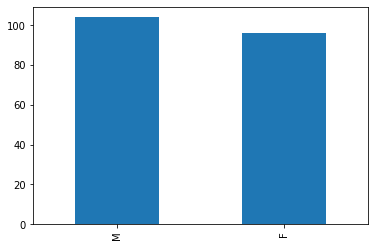

In [ ]:
ds.Sex.value_counts().plot(kind="bar")

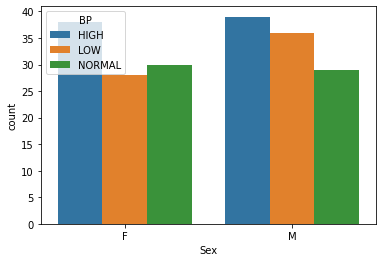

In [ ]:
sns.countplot(data=ds,x=ds.Sex,hue=ds.BP)

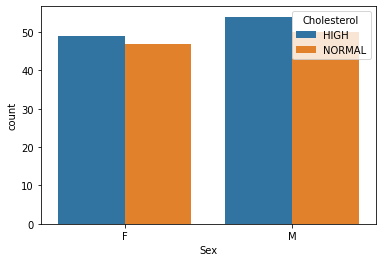

In [ ]:
sns.countplot(data=ds,hue=ds.Cholesterol,x=ds.Sex)

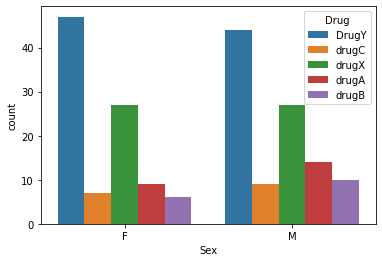

In [ ]:
sns.countplot(data=ds,x=ds.Sex,hue=ds.Drug)

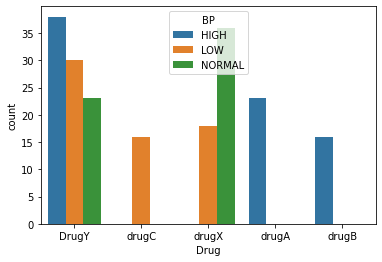

In [ ]:
sns.countplot(data=ds,hue=ds.BP,x=ds.Drug)

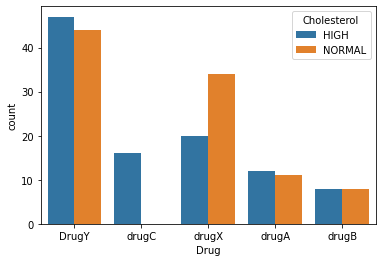

In [ ]:
sns.countplot(data=ds,hue=ds.Cholesterol,x=ds.Drug)

#### Data Preprocessing

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
np.random.seed(5)
train, val, test = np.split(ds.sample(frac=1), [int(0.8*len(ds)), int(0.9*len(ds))])

In [ ]:
train

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
119,61,F,HIGH,HIGH,25.475,DrugY
77,26,F,HIGH,NORMAL,19.161,DrugY
148,61,F,LOW,NORMAL,7.340,drugX
149,22,M,LOW,HIGH,8.151,drugC
154,37,M,LOW,NORMAL,16.724,DrugY
...,...,...,...,...,...,...
18,23,M,LOW,HIGH,7.298,drugC
147,26,F,HIGH,NORMAL,12.307,drugA
163,21,F,HIGH,NORMAL,28.632,DrugY
38,39,F,NORMAL,NORMAL,9.709,drugX


##### Converting to tensor slices

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=16):
  df = dataframe.copy()
  labels,indices = np.unique(df["Drug"],return_inverse=True) 
  df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
  df.pop('Drug')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), tf.one_hot(indices,5)))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
batch_size=1
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

In [ ]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = tf.keras.layers.Normalization(axis=None)
  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)
  return normalizer

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  
  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [ ]:
numerical_cols = ["Age","Na_to_K"]
categorical_cols = ["Sex","BP","Cholesterol"]

all_inputs = []
encoded_features = []

# Numerical features.
for header in numerical_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds) # Normalization
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Other categorical Features
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,dataset=train_ds,dtype='string',max_tokens=5) # encoding
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

#### Model

In [ ]:
#  functional API
x = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
x = tf.keras.layers.Dense(5, activation="relu")(x)
x = tf.keras.layers.Dense(5, activation="relu")(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(all_inputs,outputs)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=100,
                    callbacks=tf.keras.callbacks.EarlyStopping(patience=5)
                    )

Epoch 1/100
160/160 [==============================] - 1s 4ms/step - loss: 1.5157 - accuracy: 0.4187 - val_loss: 1.4055 - val_accuracy: 0.7000
Epoch 2/100
160/160 [==============================] - 0s 3ms/step - loss: 1.2966 - accuracy: 0.5875 - val_loss: 1.2651 - val_accuracy: 0.6000
Epoch 3/100
160/160 [==============================] - 0s 3ms/step - loss: 1.0181 - accuracy: 0.6000 - val_loss: 0.9902 - val_accuracy: 0.6000
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 0.7897 - accuracy: 0.6812 - val_loss: 0.7994 - val_accuracy: 0.7000
Epoch 5/100
160/160 [==============================] - 0s 2ms/step - loss: 0.6497 - accuracy: 0.7063 - val_loss: 0.6700 - val_accuracy: 0.7000
Epoch 6/100
160/160 [==============================] - 0s 3ms/step - loss: 0.5730 - accuracy: 0.7063 - val_loss: 0.5991 - val_accuracy: 0.7000
Epoch 7/100
160/160 [==============================] - 0s 3ms/step - loss: 0.5244 - accuracy: 0.7188 - val_loss: 0.5679 - val_accuracy: 0.7000

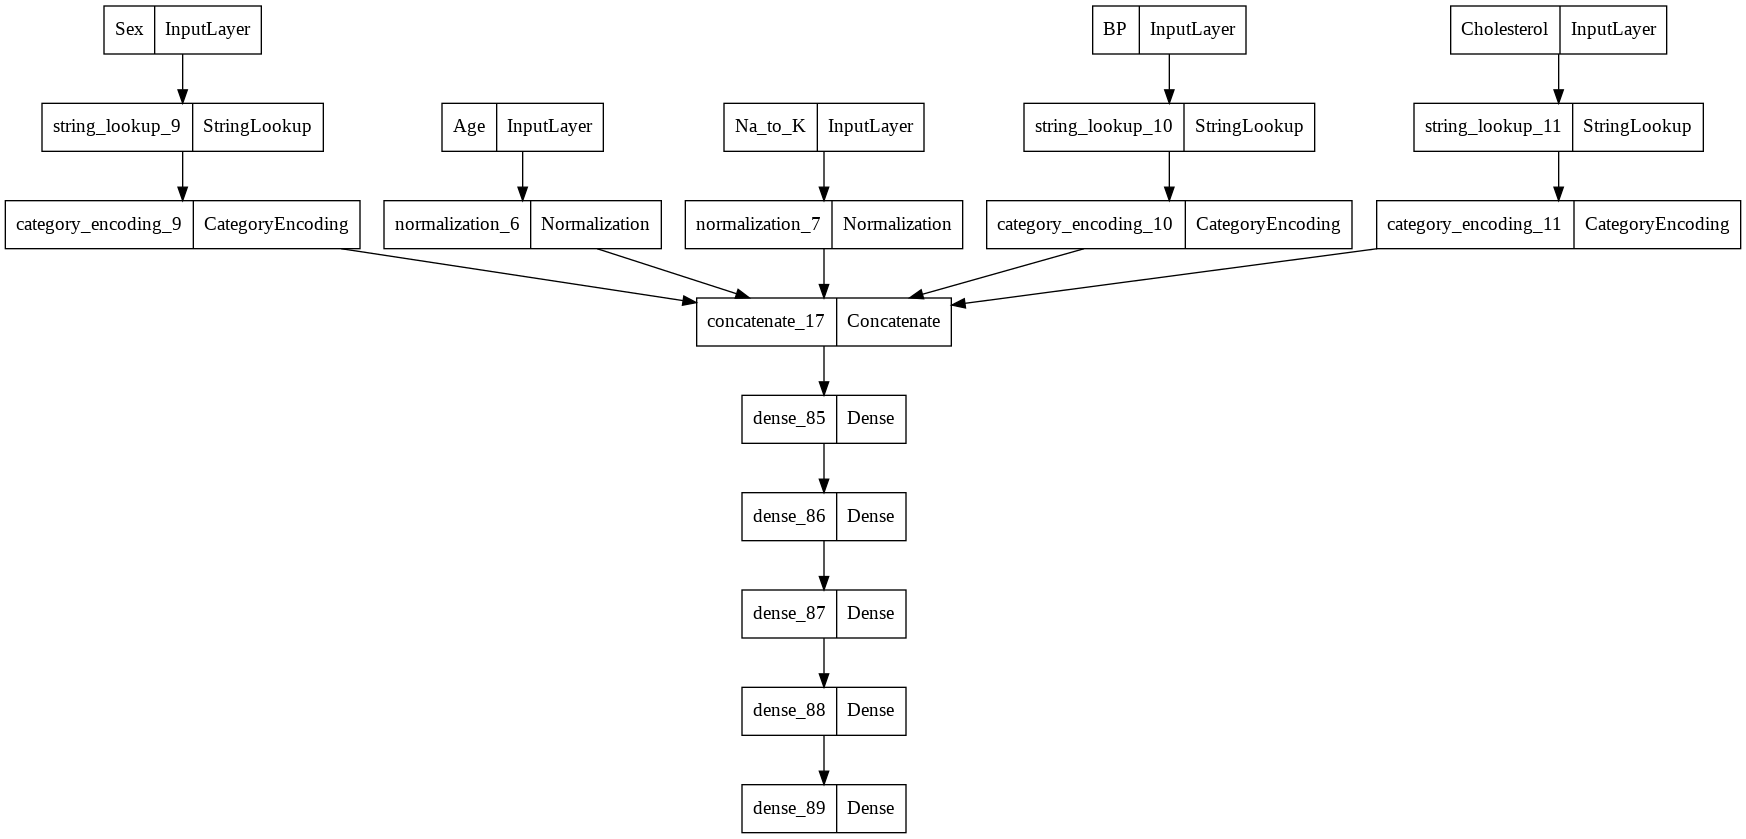

In [ ]:
tf.keras.utils.plot_model(model)

#### Plotting Learning curves

In [ ]:
import matplotlib.pyplot as plt
history = history.history

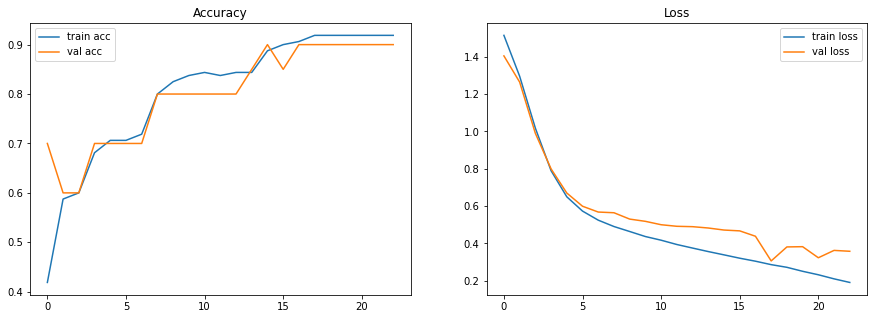

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()

#### Saving the model

In [ ]:
def model_save(filename,hist=history,path="drive/MyDrive/dataset/internship/models/"):
  pd.DataFrame(hist).to_csv(path+filename+".csv",index=False)
  model.save(path+filename+".tf")
model_save('2_drug')

In [ ]:
loss ,accuracy = model.evaluate(test_ds)


2/2 [==============================] - 0s 7ms/step - loss: 0.1866 - accuracy: 0.9500


In [ ]:
labels,indices = np.unique(ds["Drug"],return_inverse=True)
tf.one_hot(indices,5)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
prediction=np.argmax(new_m.predict(train_ds),axis=1)

In [ ]:
actual=pd.get_dummies(train.Drug).to_numpy()
actual=np.argmax(actual,axis=1)

In [ ]:
print(classification_report(actual,prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       0.70      1.00      0.83        19
           2       1.00      0.15      0.27        13
           3       0.79      1.00      0.88        11
           4       1.00      1.00      1.00        39

    accuracy                           0.93       160
   macro avg       0.90      0.83      0.79       160
weighted avg       0.95      0.93      0.91       160

